In [12]:
import plotly.io as pio
from sklearn.datasets import fetch_openml
from IPython.display import clear_output
from sys import stdout
from difflib import SequenceMatcher
from scipy import ndimage
import cv2
from io import StringIO
import urllib
import joblib
from sklearn.manifold import TSNE
from skimage.feature import hog
from skimage.transform import resize
from skimage import data, color, exposure, measure
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn import linear_model, datasets, metrics
import pandas as pd
import sklearn
import scipy
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [13]:
Method_Used = 'load'
datasets_1 = False
cl_load = False
cl_save = True
enable_error_output = False

py.init_notebook_mode(connected=True)

In [14]:
df = pd.read_csv('handwritten.csv', sep=',', header=None)
df

,0,1,2,3
0,_unit_id,image_url,transcription,first_or_last
1,952459271,http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...,HIMELIN,first
2,952459272,http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...,ROBIN,first
3,952459273,http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...,YOANN,first
4,952459274,http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...,MARTIN,first
...,...,...,...,...
129985,950638022,http://crl.checkbacksoon.nl/dls/dss/d2m/15/sur...,LEGRIS,last
129986,950638023,http://crl.checkbacksoon.nl/dls/dss/d2m/15/sur...,OTTAVI,last
129987,950638024,http://crl.checkbacksoon.nl/dls/dss/d2m/15/sur...,DESAFERNANDES,last
129988,950638025,http://crl.checkbacksoon.nl/dls/dss/d2m/15/sur...,CANTONI,last


In [15]:
def Display_Function(prct, msg=None):
    if prct > 100 or prct < 0:
        return
    clear_output(wait=True)
    if msg is None:
        print("Progress: [", end="")
    else:
        print(msg + " [", end="")
    end = int(prct / 10)
    for _ in range(end):
        print("=", end="")
    for _ in range(end, 10):
        print(" ", end="")
    print("] " + str(prct) + "%", end="")
    stdout.flush()

In [16]:
def Border_Elimination(crop):
    cropf = ndimage.gaussian_filter(crop, 0.5)
    cropbin = (cropf < 0.8)
    data_label, object_inr = ndimage.label(cropbin)
    labels_to_delete = [data_label[data_label.shape[0]-1, i]
                        for i in range(data_label.shape[1]) if data_label[data_label.shape[0]-1, i] > 0]

    for x in range(data_label.shape[1]):
        for y in range(data_label.shape[0]):
            if data_label[y, x] in labels_to_delete:
                crop[y, x] = 1.0

    return crop

In [17]:
def Word_Extract(index, dataframe):
    try:
        urllib.request.urlretrieve(dataframe[1][index], "temp.jpg")
    except urllib.error.URLError as e:
        return None, False

    img = cv2.imread('temp.jpg')
    img_height, img_width = img.shape[:-1]
    img_rgb = img.copy()

    template = cv2.imread('template.png')
    template_height, template_width = template.shape[:-1]

    template_match_success = False
    res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
    threshold = 0.7
    loc = np.where(res >= threshold)

    for pt in zip(*loc[::-1]):
        cv2.rectangle(
            img_rgb, pt, (pt[0] + template_width, pt[1] + template_height), (0, 0, 255), 2)
        crop_height_start = pt[1]
        crop_height_end = pt[1] + template_height
        crop_width = pt[0] + template_width
        template_match_success = True

    if not template_match_success:
        return img, False

    if dataframe[3][index] == 'first' or dataframe[3][index] == 'last':
        crop = img.copy()[max(crop_height_start - 6, 0)
                        :min(crop_height_end + 6, img_height), crop_width:img_width]
    else:
        crop = img.copy()[
            max(min(crop_height_end + 4, img_height - 1), 0):img_height, :]

    crop = color.rgb2gray(crop)
    if dataframe[3][index] == 'first_b' or dataframe[3][index] == 'last_b':
        crop = Border_Elimination(crop)
    return crop, True


In [19]:
def gen_dataset(n=df.shape[0]):
    data = []
    labels = []

    for i in range(1, n):
        crop, success = Word_Extract(i)
        if success:
            data.append(crop)
            labels.append(df[2][i])
        else:
            if enable_error_output:
                print(i)
    return data, labels

In [20]:
dataset = np.load("HandwrittenNames_data.npz", allow_pickle=True)['data']
labels = np.load("HandwrittenNames_labels.npz", allow_pickle=True)['data']

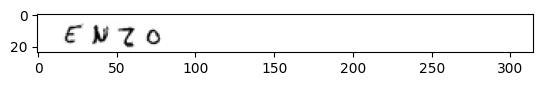

ENZO


In [22]:
if (datasets_1):
    np.savez("HandwrittenNames_data.npz", data=dataset)
    np.savez("HandwrittenNames_labels.npz", data=labels)

selection = 20
plt.imshow(dataset[selection], cmap='gray')
plt.show()
print(labels[selection])

In [23]:
def Label_Infromation(crop):
    img = crop.copy()
    threshold = 0.8
    data_label, object_inr = ndimage.label(img < threshold)
    return data_label, object_inr


In [24]:
def Box_Genrator(data_label, object_inr):
    array = np.zeros((object_inr, 2, 2), dtype='int')

    x1, y1, x2, y2 = 0, data_label.shape[0], 0, 0
    coord = 0
    cont = 0

    for x in range(data_label.shape[1]):
        nzero, firstb = False, False
        ytop, ybot = 0, 0

        for y in range(data_label.shape[0]):
            if data_label[y][x] > 0:
                nzero = True
                if not firstb:
                    ytop = y
                    firstb = True
                ybot = y

        if nzero:
            if ytop < y1:
                y1 = ytop
            if ybot > y2:
                y2 = ybot
            if coord == 0:
                x1 = x
                coord = 1
            elif coord == 1:
                x2 = x
        elif not nzero and coord == 1:
            array[cont][0] = [x1, y1]
            array[cont][1] = [x2, y2]
            cont += 1
            coord = 0
            x1, y1, x2, y2 = 0, data_label.shape[0], 0, 0

    array = array[:cont]
    return array, cont

In [37]:
def Alphabet_crop(img, bboxes, n):
    characters = []
    for i in range(0, n):
        c = img.copy()[bboxes[i][0][1]:bboxes[i][1][1], bboxes[i][0][0]:bboxes[i][1][0]]
        if (c.shape[0] != 0 and c.shape[1] != 0):
            c = resize(c, (28, 28), mode='constant', cval=1.0, clip=True)
            characters.append((c<0.80).reshape(784))
    return characters, len(characters)


In [38]:
def process_label(label):
    if isinstance(label, str) or isinstance(label, np.str_):
        temp1 = list(label)
        temp = []
        i = 0
        while i < len(temp1):
            if temp1[i] != ' ':
                temp.append(temp1[i])
            i += 1
        return temp
    else:
        return []


In [39]:
def generate_charaters(image, label):
    data_label, object_inr = Label_Infromation(image)
    array, n = Box_Genrator(data_label, object_inr)
    characters, n_chars = Alphabet_crop(image, array, n)
    labels = process_label(label)
    return characters, labels[0:n_chars]

In [40]:
def img_characters(image):
    data_label, object_inr = Label_Infromation(image)
    array, n = Box_Genrator(data_label, object_inr)
    characters, n_chars = Alphabet_crop(image, array, n)
    return characters

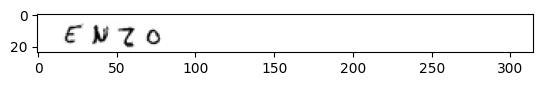

ENZO


In [47]:
selection = 20
plt.imshow(dataset[selection], cmap='gray')
plt.show()
print(labels[selection])

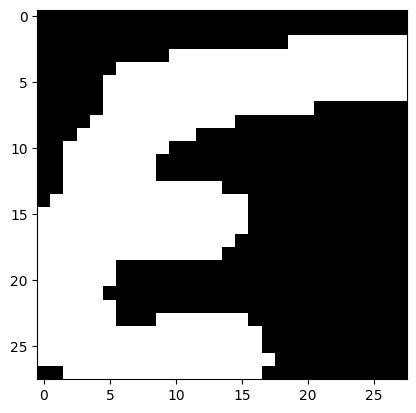

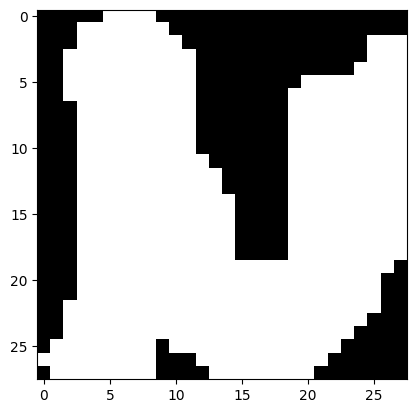

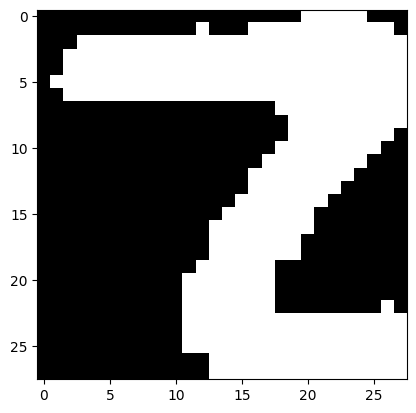

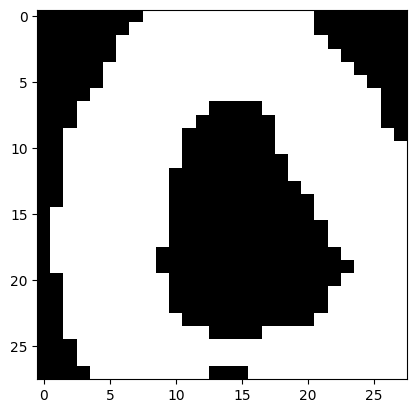

In [48]:
characters, ch_label = generate_charaters(
    dataset[selection], labels[selection])

for i in range(0, len(characters)):
    plt.imshow(characters[i].reshape(28, 28), cmap='gray')
    plt.show()

In [49]:
ver_check = True

rbm = BernoulliRBM(n_components=300, learning_rate=0.01, n_iter=45, random_state=0, verbose=ver_check)
mlp = MLPClassifier(hidden_layer_sizes=(300, 400, 150), activation='relu',max_iter=5000, tol=0.0001, random_state=1, verbose=ver_check)
Rbm_Mlp = Pipeline(steps=[('rbm', rbm), ('mlp', mlp)])

In [50]:
Mlp_Hog = MLPClassifier(hidden_layer_sizes=(300, 400, 150), max_iter=5000, tol=0.001, random_state=1, verbose=ver_check)
Mlp_Pca = MLPClassifier(hidden_layer_sizes=(300, 400, 150), max_iter=5000, tol=0.0001, random_state=1, verbose=ver_check)

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset, labels, test_size=0.2, random_state=0)

In [52]:
x_train_ch = []
y_train_ch = []
array_of_train = []
z = 0
for i in range(len(X_train)):
    characters, ch_label = generate_charaters(X_train[i], Y_train[i])

    if len(characters) != len(ch_label) or len(characters) == 0 or len(ch_label) == 0:
        if enable_error_output:
            print("Error!!!")
        array_of_train.append(i)
        z += 1
    else:
        x_train_ch.extend(characters)
        y_train_ch.extend(ch_label)

In [53]:
x_test_ch = []
y_test_ch = []
array_of_test = []
z = 0
for i in range(len(X_test)):
    characters, ch_label = generate_charaters(X_test[i], Y_test[i])
    if (len(characters) != len(ch_label) or len(characters) == 0 or len(ch_label) == 0):
        if (enable_error_output):
            print("Error!!!")
        z += 1
    else:
        x_test_ch.extend(characters)
        y_test_ch.extend(ch_label)
        array_of_test.append(i)

In [54]:
Train_FD = np.zeros((len(x_train_ch), 392))
for i in range(0, len(x_train_ch)):
    Train_FD[i], hog_image = hog(x_train_ch[i].reshape(
        28, 28), orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=True)

Test_FD = np.zeros((len(x_test_ch), 392))
for i in range(0, len(x_test_ch)):
    Test_FD[i], hog_image = hog(x_test_ch[i].reshape(
        28, 28), orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=True)

In [55]:
def HOG_trans(chars):
    Hog_fd = np.zeros((len(chars), 392))
    for i in range(0, len(chars)):
        Hog_fd[i], hog_image = hog(chars[i].reshape(28, 28), orientations=8, pixels_per_cell=(
            4, 4), cells_per_block=(1, 1), visualize=True)

    return Hog_fd

In [56]:
def HOG_Image(char):
    Hog_fd = np.zeros((392))
    Hog_fd, hog_image = hog(char.reshape(28, 28), orientations=8, pixels_per_cell=(
        4, 4), cells_per_block=(1, 1), visualize=True)
    return hog_image

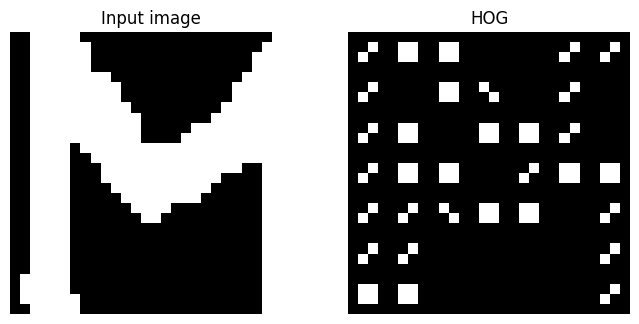

In [57]:
selection = 50
hog_image = HOG_Image(x_train_ch[selection])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(x_train_ch[selection].reshape(28, 28), cmap=plt.cm.gray)
ax1.set_title('Input image')

h_img_res = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))
ax2.axis('off')
ax2.imshow(h_img_res, cmap=plt.cm.gray)
ax2.set_title('HOG')
plt.show()

In [58]:
Scaler = StandardScaler().fit(x_train_ch)
x_pca_train = Scaler.transform(x_train_ch)
pca = PCA(n_components=100)
pca.fit(x_pca_train)
P_train = pca.transform(x_pca_train)
x_pca_test = Scaler.transform(x_test_ch)
P_test = pca.transform(x_pca_test)

In [59]:
def PCA_trans(chars):
    X_pca = Scaler.transform(chars)
    P = pca.transform(X_pca)
    return P


limit = 1000
t1 = y_train_ch[:limit]
clr = y_train_ch[:limit]
for i in range(0, len(clr)):
    clr[i] = ord(clr[i])

In [60]:
Characters = go.Scatter(
    x=P_train[:limit, 0],
    y=P_train[:limit, 1],
    name=str(t1),
    hoveron='points',
    mode='markers',
    text=t1,
    showlegend=True,
    marker=dict(
        size=8,
        color=clr,
        colorscale='Jet',
        showscale=False,
        line=dict(
            width=2,
            color='rgb(255, 255, 255)'
        ),
        opacity=0.8
    )
)

In [61]:
data = [Characters]

layout = go.Layout(
    title='Principal Component Analysis (PCA)',
    hovermode='closest',
    xaxis=dict(
        title='First Principal Component',
        ticklen=5,
        zeroline=False,
        gridwidth=2,
    ),
    yaxis=dict(
        title='Second Principal Component',
        ticklen=5,
        gridwidth=2,
    ),
    showlegend=True
)


[BernoulliRBM] Iteration 1, pseudo-likelihood = -224.09, time = 55.95s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -191.00, time = 56.27s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -185.30, time = 58.82s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -169.66, time = 51.51s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -166.83, time = 43.26s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -157.76, time = 43.40s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -163.76, time = 43.91s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -156.19, time = 43.63s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -160.92, time = 54.74s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -156.35, time = 59.22s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -153.81, time = 78.33s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -153.90, time = 72.15s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -147.31, time = 77.84s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -153.01, time = 71.13s
[

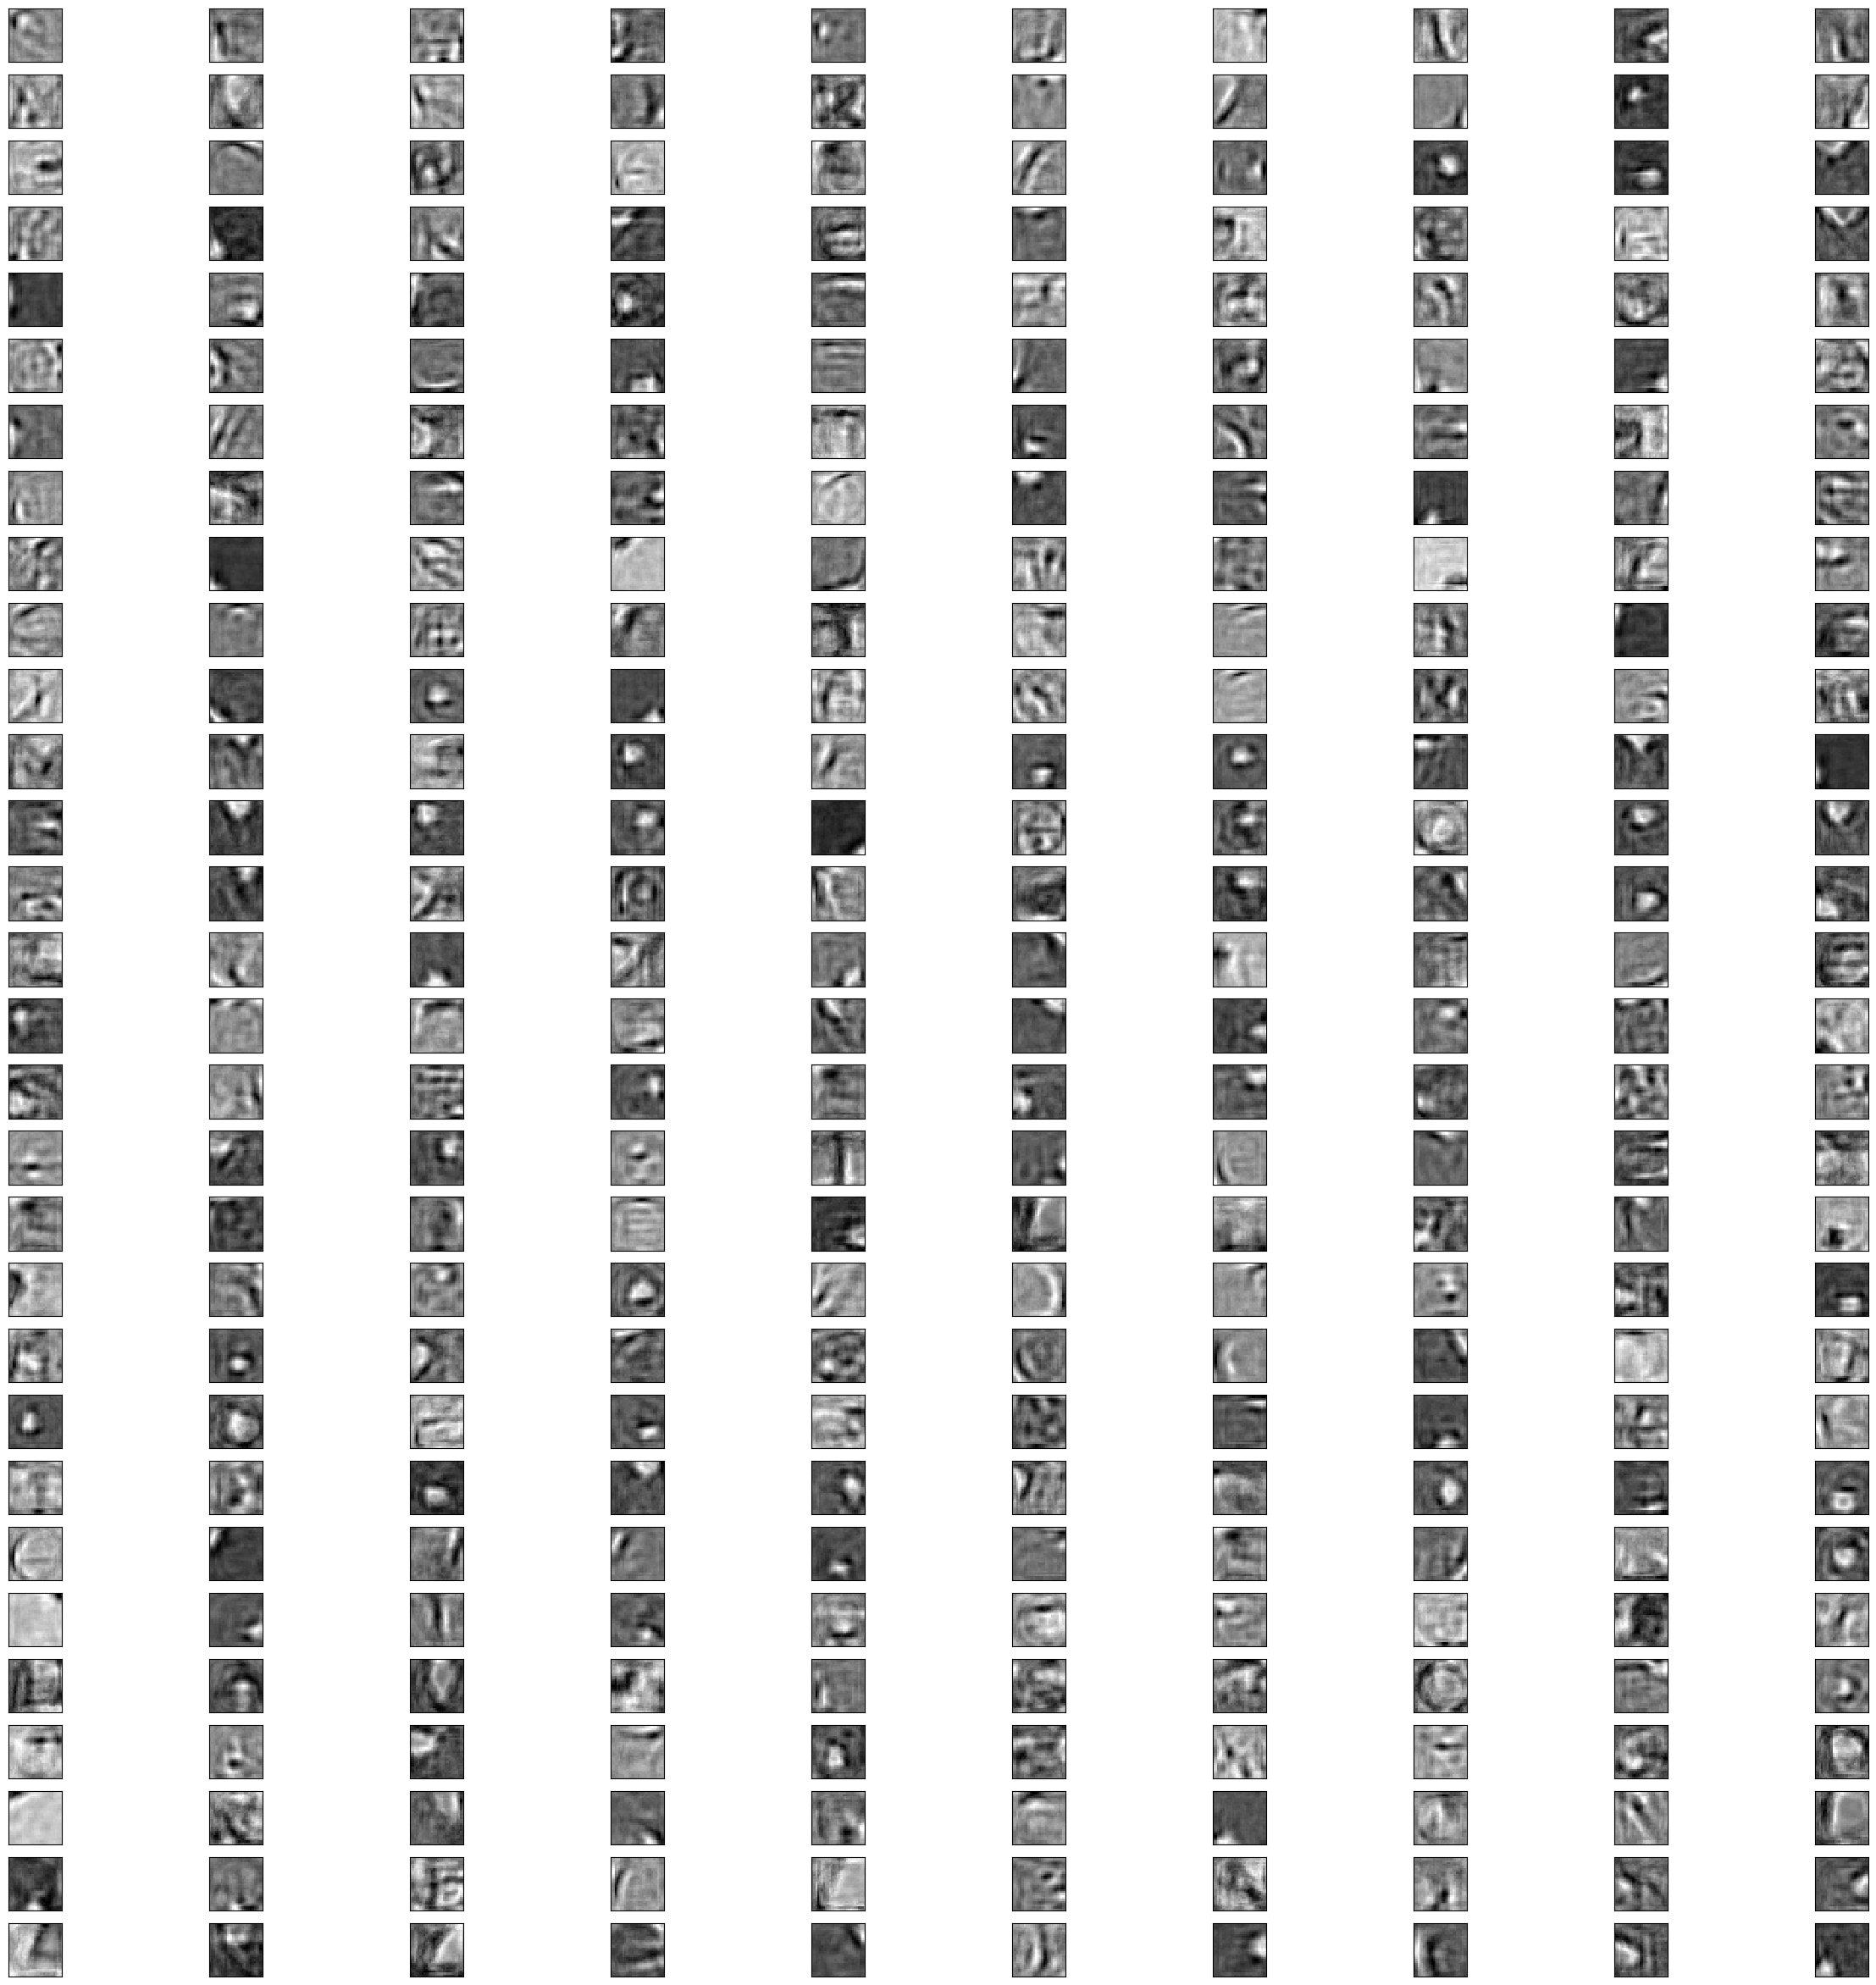

Iteration 1, loss = 0.81439170
Iteration 2, loss = 0.43829550
Iteration 3, loss = 0.37439049
Iteration 4, loss = 0.33186410
Iteration 5, loss = 0.29266071
Iteration 6, loss = 0.25736181
Iteration 7, loss = 0.22719735
Iteration 8, loss = 0.19479108
Iteration 9, loss = 0.18032531
Iteration 10, loss = 0.14328258
Iteration 11, loss = 0.11679489
Iteration 12, loss = 0.09375227
Iteration 13, loss = 0.07335518
Iteration 14, loss = 0.05757558
Iteration 15, loss = 0.04432653
Iteration 16, loss = 0.03723216
Iteration 17, loss = 0.02703017
Iteration 18, loss = 0.02754611
Iteration 19, loss = 0.02540195
Iteration 20, loss = 0.02062240
Iteration 21, loss = 0.02435742
Iteration 22, loss = 0.03473602
Iteration 23, loss = 0.03182325
Iteration 24, loss = 0.02406894
Iteration 25, loss = 0.01799775
Iteration 26, loss = 0.01181367
Iteration 27, loss = 0.01541406
Iteration 28, loss = 0.03059843
Iteration 29, loss = 0.02350312
Iteration 30, loss = 0.01515943
Iteration 31, loss = 0.01944788
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(300, 400, 150), max_iter=5000, random_state=1,
              verbose=True)

In [62]:
fig = go.Figure(data=data, layout=layout)
pio.show(fig, filename='styled-scatter')

Rbm_Mlp.fit(x_train_ch[:], y_train_ch)
rbm_plot = True

if (rbm_plot):
    plt.figure(figsize=(28, 28))
    for i, comp in enumerate(rbm.components_):
        plt.subplot(30, 10, i+1)
        plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r,
                   interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

    plt.show()

Mlp_Hog.fit(Train_FD, y_train_ch)
Mlp_Pca.fit(P_train, y_train_ch)

In [63]:
def predict_name(name, classifier, transform=None):
    characters = img_characters(name)
    
    if transform == 'hog':
        predictions = classifier.predict(HOG_trans(characters))
    elif transform == 'pca':
        predictions = classifier.predict(PCA_trans(characters))
    else:
        predictions = classifier.predict(characters)
    
    predicted_string = ''.join(predictions)
    
    return predicted_string


In [64]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [65]:
def predict2(classifier, transform=None):
    correct = 0.0
    correct_recognition = 0
    
    for i in range(len(array_of_test)):
        p_result = predict_name(X_test[array_of_test[i]], classifier, transform)
        
        if p_result == Y_test[array_of_test[i]]:
            correct_recognition += 1
        correct += similar(p_result, Y_test[array_of_test[i]])
        
        Display_Function(i * 100 / len(X_test), "Making predictions " + str(i) + "/" + str(len(X_test)) + ":")
    
    Display_Function(100, "Making predictions " + str(len(X_test)) + "/" + str(len(X_test)) + ":")
    
    return correct_recognition / len(array_of_test), correct / len(array_of_test)

In [66]:
mlp_prediction_HOG = Mlp_Hog.predict(Test_FD)
mlp_prediction_PCA = Mlp_Pca.predict(P_test)

print("HOG + MLP classification:\n%s\n" % (metrics.classification_report(y_test_ch, mlp_prediction_HOG)))
print("PCA + MLP classification:\n%s\n" % (metrics.classification_report(y_test_ch, mlp_prediction_PCA)))

cr_mlp_HOG, corr_mlp_HOG = predict2(Mlp_Hog, transform='hog')
cr_mlp_PCA, corr_mlp_PCA = predict2(Mlp_Pca, transform='pca')

Making predictions 1997/1997: [==========] 100%

In [67]:
print("========================================================================")
print("| MLP with HOG features | {:.2f}     | {:.2f} |".format(cr_mlp_HOG, corr_mlp_HOG))
print("========================================================================")
print("| MLP with PCA features | {:.2f}     | {:.2f} |".format(cr_mlp_PCA, corr_mlp_PCA))
print("========================================================================")

| MLP with HOG features | 0.64     | 0.91 |
| MLP with PCA features | 0.64     | 0.92 |


> Real label: BASTIEN
> Image:


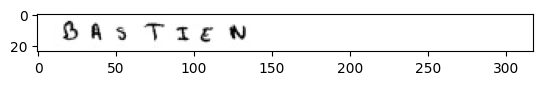

MLP with HOG features predicted: AASTIEN
MLP with PCA features predicted: BASTIEN
> Real label: MATTHIEU
> Image:


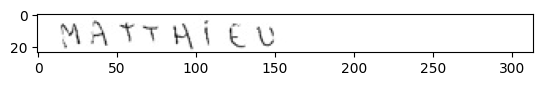

MLP with HOG features predicted: MATTHIEU
MLP with PCA features predicted: MATTMIEU
> Real label: TESSA
> Image:


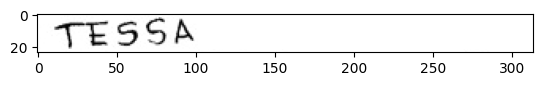

MLP with HOG features predicted: RSSA
MLP with PCA features predicted: TSSA
> Real label: AYMERIC
> Image:


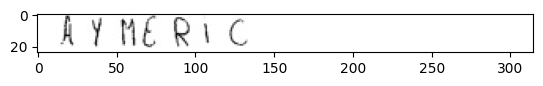

MLP with HOG features predicted: AYMERIC
MLP with PCA features predicted: AYMERIC
> Real label: ELSA
> Image:


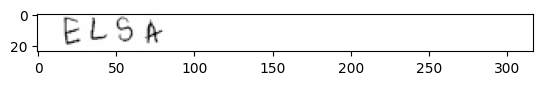

MLP with HOG features predicted: ELSA
MLP with PCA features predicted: ELSA


In [68]:
indexes = [8, 10, 12, 14, 16]
for ind in indexes:
    mlp_hog_predict = predict_name(X_test[ind], Mlp_Hog, 'hog')
    mlp_pca_predict = predict_name(X_test[ind], Mlp_Pca, 'pca')
    print("> Real label: "+Y_test[ind])
    print("> Image:")
    plt.imshow(X_test[ind], cmap='gray')
    plt.show()
    print("MLP with HOG features predicted: "+mlp_hog_predict)
    print("MLP with PCA features predicted: "+mlp_pca_predict)